<a href="https://colab.research.google.com/github/Zulfahanamaulida/TA_Deteksi-Residu-Pestisida/blob/main/Experiment_A_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data input : Data image binary dari citra 0 (without_pesticide) dan 10 (with_pesticide) mg/l | Without augmentation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import tensorflow as tf

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = "/content/drive/MyDrive/Experiment A/Dataset"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")


In [5]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_names = os.listdir(train_dir)
print(train_names)

validation_names = os.listdir(validation_dir)
print(validation_names)

test_names = os.listdir(test_dir)
print(test_names)


['with_pesticide', 'without_pesticide']
['without_pesticide', 'with_pesticide']
['without_pesticide', 'with_pesticide']


In [21]:
train_with_pesticide_dir = "/content/drive/MyDrive/Experiment A/Dataset/train/with_pesticide"
train_without_pesticide_dir = "/content/drive/MyDrive/Experiment A/Dataset/train/without_pesticide"

validation_with_pesticide_dir = "/content/drive/MyDrive/Experiment A/Dataset/validation/with_pesticide"
validation_without_pesticide_dir = "/content/drive/MyDrive/Experiment A/Dataset/validation/without_pesticide"

test_with_pesticide_dir = "/content/drive/MyDrive/Experiment A/Dataset/test/with_pesticide"
test_without_pesticide_dir = "/content/drive/MyDrive/Experiment A/Dataset/test/without_pesticide"


Samples from train_with_pesticide_dir:


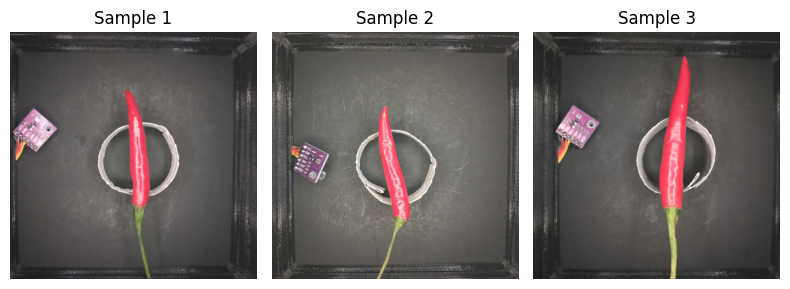

Samples from train_without_pesticide_dir:


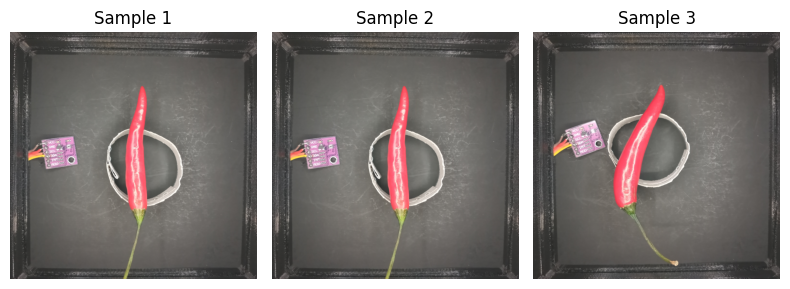

Samples from validation_with_pesticide_dir:


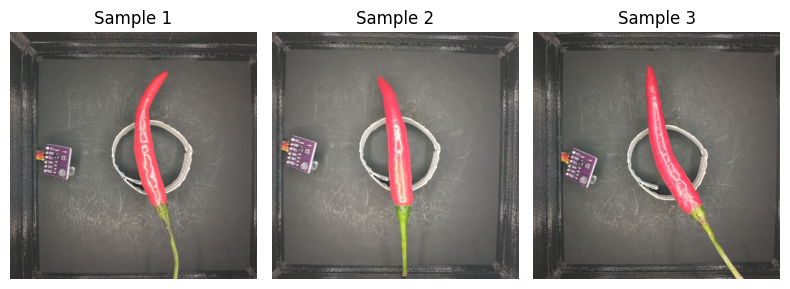

Samples from validation_without_pesticide_dir:


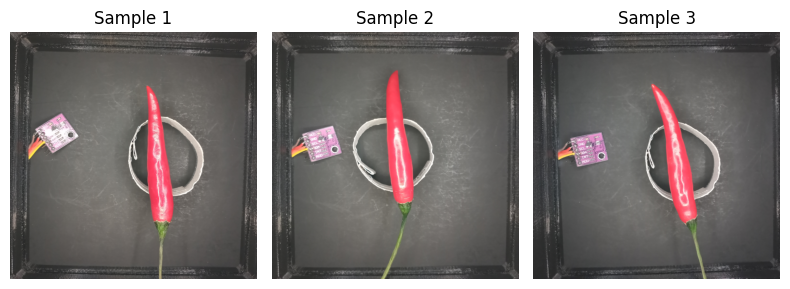

Samples from test_with_pesticide_dir:


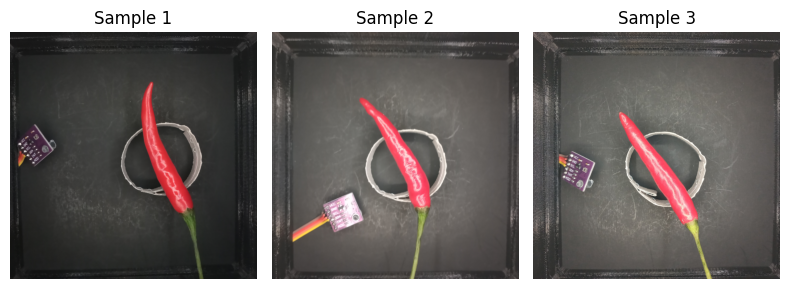

Samples from test_without_pesticide_dir:


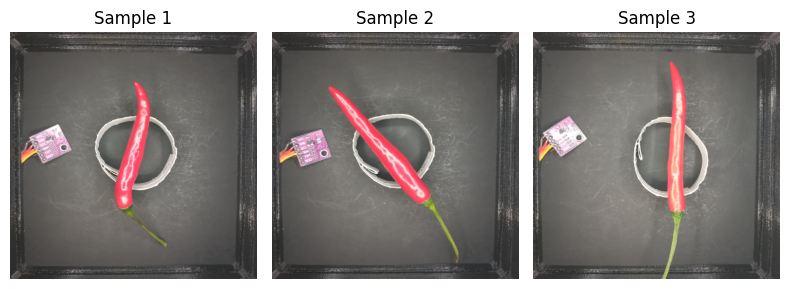

In [36]:
def display_sample_images(directory, num_samples=3):
    if not os.path.exists(directory):
        print(f"Directory '{directory}' not found.")
        return

    fig, axes = plt.subplots(1, num_samples, figsize=(8, 4))  # Adjusted figure size
    for idx, filename in enumerate(os.listdir(directory)[:num_samples]):
        img = mpimg.imread(os.path.join(directory, filename))
        axes[idx].imshow(img)
        axes[idx].set_title(f"Sample {idx+1}")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images from each directory
print("Samples from train_with_pesticide_dir:")
display_sample_images(train_with_pesticide_dir)

print("Samples from train_without_pesticide_dir:")
display_sample_images(train_without_pesticide_dir)

print("Samples from validation_with_pesticide_dir:")
display_sample_images(validation_with_pesticide_dir)

print("Samples from validation_without_pesticide_dir:")
display_sample_images(validation_without_pesticide_dir)

print("Samples from test_with_pesticide_dir:")
display_sample_images(test_with_pesticide_dir)

print("Samples from test_without_pesticide_dir:")
display_sample_images(test_without_pesticide_dir)


In [23]:
train_datagen = ImageDataGenerator(rescale = 1/255)

validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                            target_size = (28, 28),
                                            batch_size = 2,
                                            class_mode = 'categorical',
                                            color_mode= 'rgb',
                                            shuffle= True)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                             target_size = (28, 28),
                                             batch_size = 2,
                                             class_mode = 'categorical',
                                             color_mode = 'rgb',
                                             shuffle = True)

Found 12 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [24]:
class_pesticide_dict = train_generator.class_indices
classes_pesticide = list(class_pesticide_dict.keys())
number_of_classes=len(classes_pesticide)

print ("List Classes of Pesticide:", classes_pesticide)
print ("Class Dictionary of Pesticide :", class_pesticide_dict)
print ("Total of Pesticide Classes :", number_of_classes)

List Classes of Pesticide: ['with_pesticide', 'without_pesticide']
Class Dictionary of Pesticide : {'with_pesticide': 0, 'without_pesticide': 1}
Total of Pesticide Classes : 2


In [25]:
def create_sequential_model(input_shape=(28, 28, 3)):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    return model

# Create the model
model = create_sequential_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                 

In [26]:
# Compile the model with specified learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
            print("\nAccuracy has reached > 90%!")
            self.model.stop_training = True
callbacks = myCallback()

In [28]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])


Epoch 1/20
6/6 [==============================] - 5s 523ms/step - loss: 0.7069 - accuracy: 0.1667 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
6/6 [==============================] - 3s 449ms/step - loss: 0.6920 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/20
6/6 [==============================] - 3s 448ms/step - loss: 0.6900 - accuracy: 0.6667 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 3s 572ms/step - loss: 0.6895 - accuracy: 0.4167 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 2s 314ms/step - loss: 0.6778 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 6/20
6/6 [==============================] - 2s 320ms/step - loss: 0.6769 - accuracy: 0.7500 - val_loss: 0.6892 - val_accuracy: 0.6250
Epoch 7/20
6/6 [==============================] - 2s 435ms/step - loss: 0.6693 - accuracy: 0.5833 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 8/20
6/6 [====

In [29]:
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.38199523091316223
Train Accuracy: 0.9166666865348816


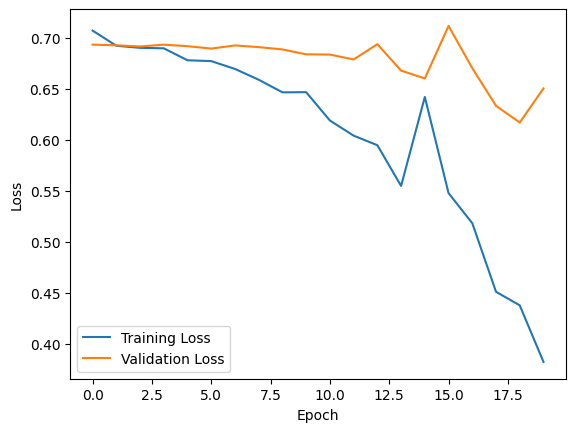

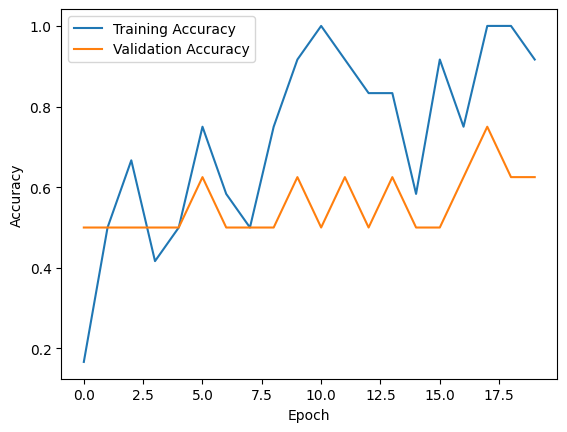

In [30]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 10 images belonging to 2 classes.
5/5 [==============================] - 1s 251ms/step


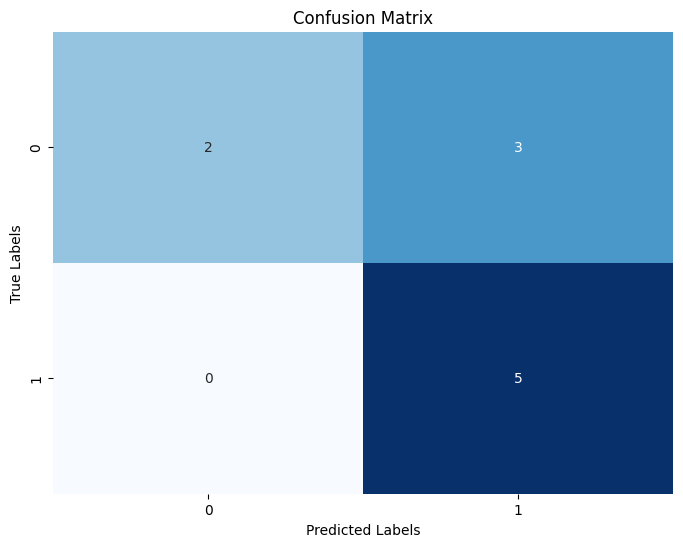

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.62      1.00      0.77         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



In [33]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(28, 28),
                                                  batch_size=2,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=False)

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred)

# Print classification report
print("Classification Report:\n", class_report)


In [34]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Experiment A/Model/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/Experiment A/Model/model.h5
